In [1]:
%matplotlib inline
import os
from os.path import join as pjoin
from tifffile import imread, imwrite, TiffFile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from tqdm import tqdm
import subprocess
from wf_utils import *
from wfield_utils import *
# from multi_load_images import *


In [2]:
### Set the file path

# path_0: including one-day recording files
# path_1: including every stimuli
path_0 = r"/home/lzx/data/WF_WRX/P42/20240726/saline"
path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n'+str(path_all))


All the file path:
['/home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy', '/home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating', '/home/lzx/data/WF_WRX/P42/20240726/saline/3_SalienceMovingGrating', '/home/lzx/data/WF_WRX/P42/20240726/saline/4_Looming', '/home/lzx/data/WF_WRX/P42/20240726/saline/5_NatureMovie']


In [3]:
### re-organize files

for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732-405Timestamp.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732-470Timestamp.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732-405
moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732-470
moving /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy/20240726-154732-event
moving /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating/20240726-160334-405Timestamp.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating/20240726-160334-470Timestamp.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating/20240726-160334.csv
moving /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating/20240726-160334-405
moving /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating/20240726-160334-470
moving /home/lzx/da

Path: /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy
experiments:
['20240726-154732']
merged 20240726-154732 has existed


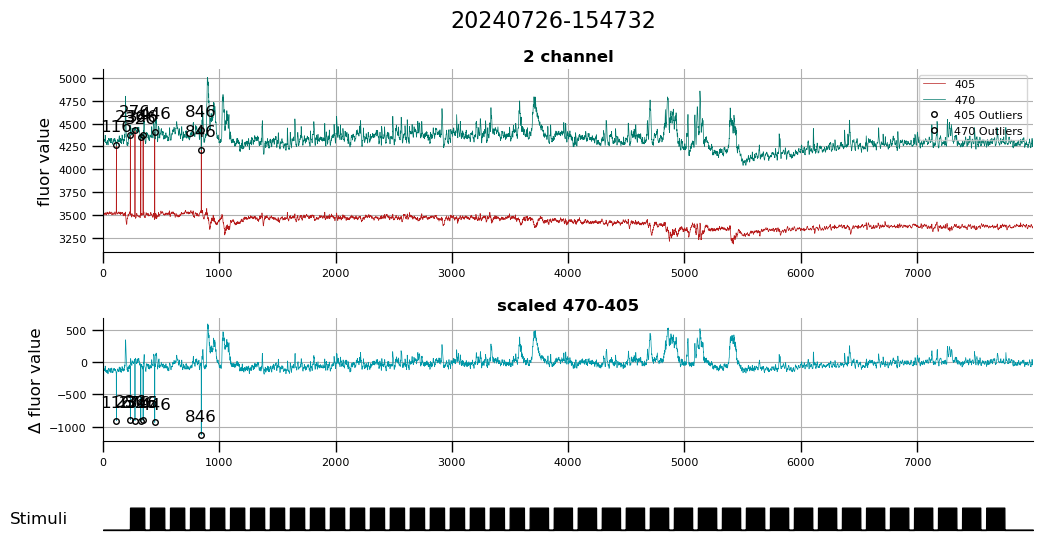


finished /home/lzx/data/WF_WRX/P42/20240726/saline/1_Retinotopy


Path: /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating
experiments:
['20240726-160334']
merged 20240726-160334 has existed


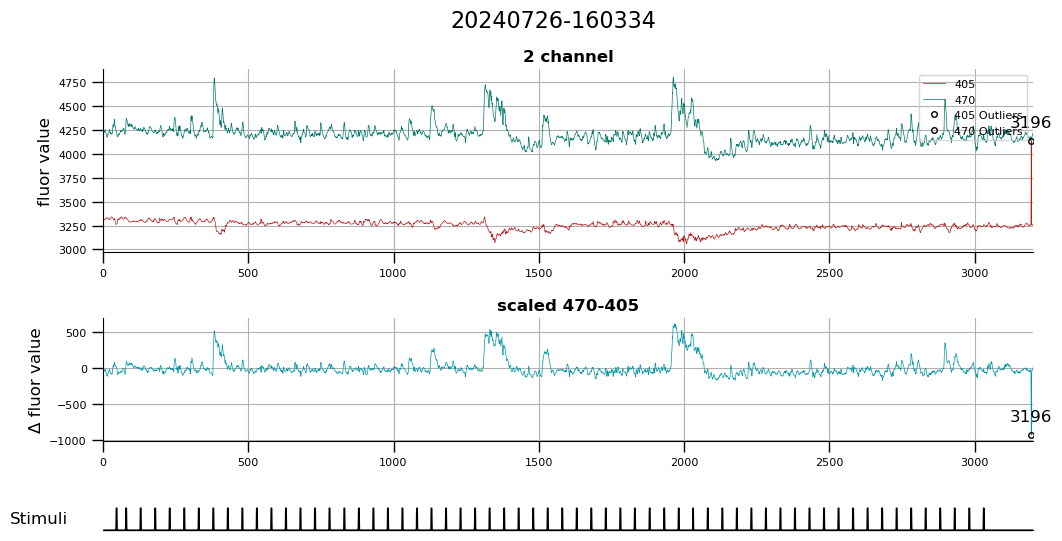


finished /home/lzx/data/WF_WRX/P42/20240726/saline/2_SalienceGrating


Path: /home/lzx/data/WF_WRX/P42/20240726/saline/3_SalienceMovingGrating
experiments:
['20240726-161157']
merged 20240726-161157 has existed


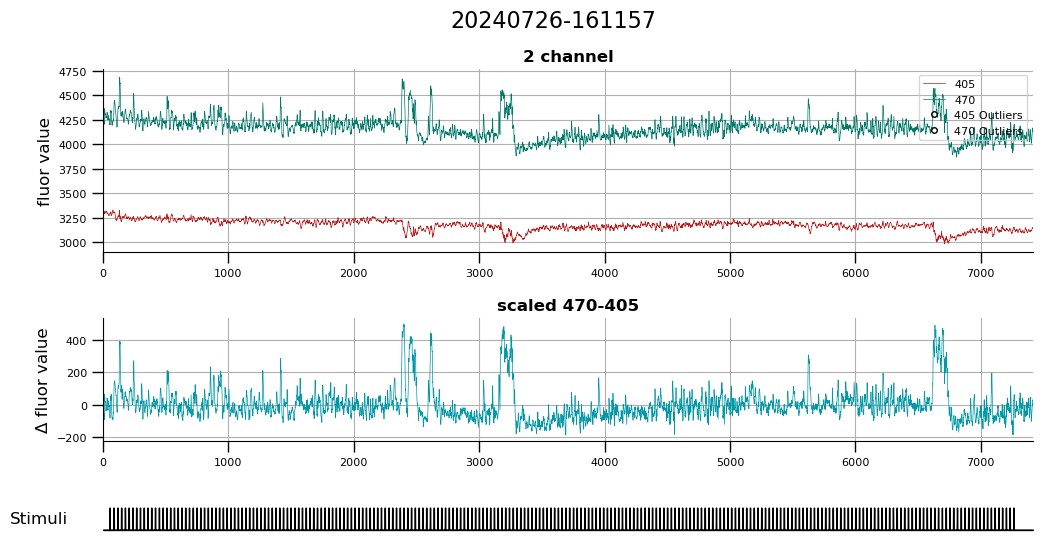


finished /home/lzx/data/WF_WRX/P42/20240726/saline/3_SalienceMovingGrating


Path: /home/lzx/data/WF_WRX/P42/20240726/saline/4_Looming
experiments:
['20240726-162517']
merged 20240726-162517 has existed


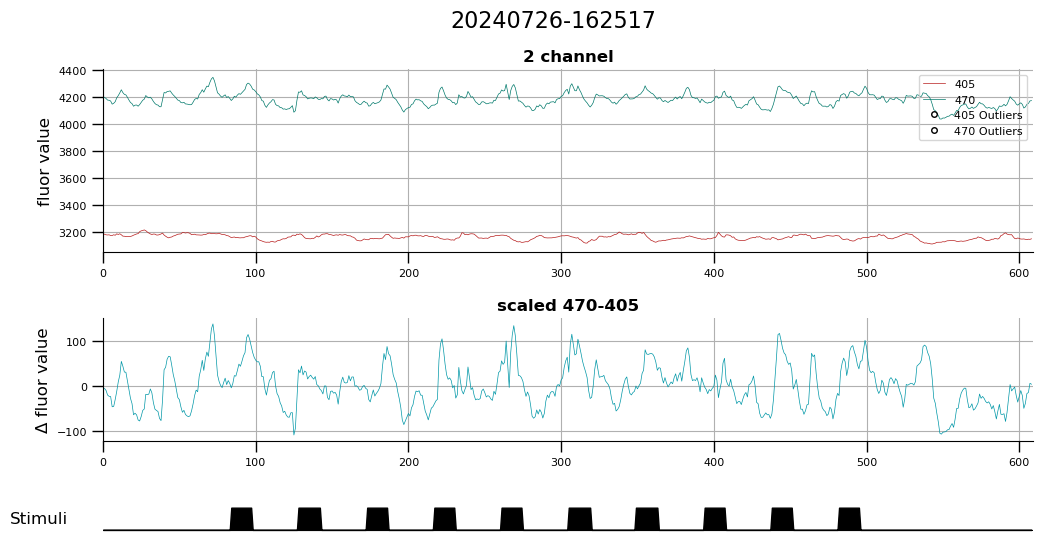


finished /home/lzx/data/WF_WRX/P42/20240726/saline/4_Looming


Path: /home/lzx/data/WF_WRX/P42/20240726/saline/5_NatureMovie
experiments:
['20240726-162733']
merged 20240726-162733 has existed


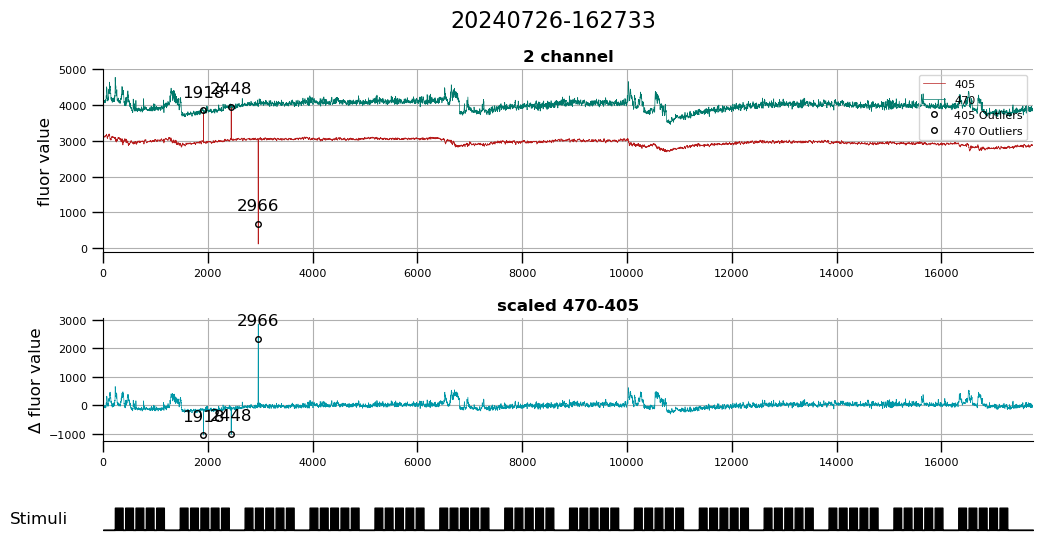


finished /home/lzx/data/WF_WRX/P42/20240726/saline/5_NatureMovie


All merging finished!


In [6]:
### generate 2-channel tif stack

def organize_tif(folder_path):
    folder_name = os.path.basename(folder_path)
    if os.path.exists(folder_path+'.tif'):
        print('importing {}.tif'.format(folder_path))
        image_stack = imread(folder_path+'.tif')
        print('finish importing {}.tif'.format(folder_path))
    else:
        image_path_ls = glob(pjoin(folder_path, '*.tif'))
        image_path_ls = sorted(image_path_ls, key = filename2int) # 确保图像帧按顺序排列
        image_stack = [imread(tiff) for tiff in log_progress(image_path_ls, name=folder_name)]  # 将多帧tif堆叠成数组
        # image_stack = multi_load_images(image_path_ls, n_thread=20)
    # rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in image_stack]   # 顺时针旋转图像90度
    # 计算并保存均值数据
    mean_values = [np.mean(frame) for frame in image_stack]
    output_value = pjoin(processPath, folder_name + "-Values.csv")
    np.savetxt(output_value, mean_values, delimiter=",")
    
    return np.array(image_stack)


for path in path_all:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"))
            tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"))
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            imwrite(merge_file, merged_tif, imagej=True, bigtiff=True)
                        
        else: print("merged "+experiment+" has existed")
        plotFluor(path, experiment)
        
    print("\nfinished "+ path+"\n\n")
    
print("All merging finished!")


### ********************************************************************************************************************
### 从这里开始用wfield软件做运动矫正、奇异值分解、血流动力学矫正。以下必须用wfield环境！！！
### ********************************************************************************************************************

In [ ]:
# try wfield

! wfield -h

In [ ]:
# 列出所有已经合并通道的tiff的路径

path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
print('All the wfield-path:\n'+"\n".join(path_wfield_all))


In [ ]:
# path_delete = glob(pjoin(path_0, '*/process/*-wfield/*.bin'))
# path_delete


In [ ]:
# for file_delete in path_delete:
#     try:
#         os.remove(file_delete)
#         print(f"Deleted: {file_delete}")
#     except Exception as e:
#         print(f"Error deleting {file_delete}: {e}")

In [ ]:
### 生成trial_onsets.npy

n_movie_rep = 5

for path_wfield in path_wfield_all:
    
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    merge_file = pjoin(path_wfield, experiment+"-merged.tif")
    n_frames = len(TiffFile(merge_file).pages)//2

    if os.path.exists(pjoin(rawPath, experiment + ".csv")):
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(path_wfield, 'trials.csv')):
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/10)
            
            stim = np.zeros(n_frames)
            for i in range(n_frames):
                stim[i] = stimfile[(i * 10 + stim_delay), 0]
            single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
            single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
            stim[single_1_indices] = 0
            stim[single_0_indices] = 1
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
            print("generate trials.csv of "+experiment)
            
            if 'retinotopy' or 'checkerboard-bar' in path_wfield:
                trial_onsets = np.stack((np.arange(len(onset)), onset - 30, offset), axis=1)  # 这个文件给wfield软件做SVD用
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
            
            elif 'natural-movie' in path_wfield:
                n_movie = len(onset)//n_movie_rep
                trial_onsets = np.empty((n_movie,3))
                for i in range(n_movie):
                    trial_onsets[i] = [i, onset[i*n_movie_rep] - 100, offset[i*n_movie_rep]]
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
            # elif 'speed' in path_wfield:
            #     trial_onsets = [0, onset[0] - 100, offset[0]]
            #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
        else: print("trials.csv of "+experiment+" has existed")

    else: print(experiment, 'without stim-file, skip')
            
print("\nAll generation of trials-file finished!")


In [ ]:
# 用wfield进行Motion correction, single value decomposition, hemodynamic correction。

for path_wfield in path_wfield_all:
    if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
        print(path_wfield,"can't find merged tiff file！\n")
    elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
        print(path_wfield,"exist multiple merged tiff file！\n")
    # elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
    #     print(path_wfield,'analysis has been finished！\n')
    else:
        print('Start analyze',path_wfield)
        if 'natural-movie' or 'speed' in path_wfield:
            nbaseline_frames = 100
        else: 
            nbaseline_frames = 30
        command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
        logfile = pjoin(path_wfield, 'log.txt')
        with open(logfile, "w") as log:
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            log.write(result.stdout)
        if result.returncode == 0:
            print('Finish analyzing',path_wfield,'\n')
        else:
            print('！！！Error occured when analyzing',path_wfield,'\n')
        
print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')


In [ ]:
# 重构矫正后图像

export_corr_tif = False

if export_corr_tif is True:
    for path_wfield in path_wfield_all:
        print('\npath', path_wfield)
        filename = os.path.basename(glob(pjoin(path_wfield, '*-merged.tif'))[0])[:16]
        if not (os.path.exists(pjoin(path_wfield, filename+"SVD_corr.tif")) or os.path.exists(pjoin(path_wfield, filename+"SVD_corr_uint16.tif")) or os.path.exists(pjoin(path_wfield, filename+"hemo-corr.tif"))):
            svd2tif(path_wfield, name=filename, uint16=False, corr470=True)
        else:
            print('reconstruction has been finished！')
        
    print('\n\nAll image reconstruction finished!')


In [ ]:
from wfield_utils import *

for path_wfield in path_wfield_all:
    if 'retinotopy' or 'checkerboard-bar' in path_wfield:
        phasemap(path_wfield, nrepeats=10, post_trial=3, export_ave_tif=False, export_raw_tif=False, 
         plot_snr=True, plot_phasemasp=True, export_phase=True)
        phasemap(path_wfield, nrepeats=10, post_trial=0, export_ave_tif=True, export_raw_tif=True, 
         plot_snr=False, plot_phasemasp=False, export_phase=False)